# Converting Arepo snapshots to be usable by TARDIS

### What is [Arepo](https://arepo-code.org/)?
> *Arepo is a massively parallel gravity and magnetohydrodynamics code for astrophysics, designed for problems of large dynamic range. It employs a finite-volume approach to discretize the equations of hydrodynamics on a moving Voronoi mesh, and a tree-particle-mesh method for gravitational interactions. Arepo is originally optimized for cosmological simulations of structure formation, but has also been used in many other applications in astrophysics.*

<cite data-cite="Weinberger2020">(Weinberger, 2020)</cite>

This parser is intended for loading Arepo output files ('snapshots'), extracting the relevant (line-of-sight dependent) data and exporting it to `csvy` files, which can in turn be used in TARDIS models ([see CSVY model](../index.rst#csvy-model)).

<div class="alert alert-info">



Note


This parser has been developed for the (not publically available) development version of Arepo, not the public version. Althought it should also work with snapshots from the public version, this has not been tested. If you run into trouble loading the snapshot using the built-in functions, try providing the data manually.    


</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tardis.io.parsers import arepo
import json
%matplotlib inline

/usr/share/miniconda3/envs/tardis/lib/python3.8/site-packages/traitlets/traitlets.py:3044: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

### Loading the simulation data

As a first step, the relevant data has to be loaded from an Arepo snapshot, i.e. an output file of Arepo. In case you have the arepo-snap-util package installed, you can use the built in wrapper (as described below) to load the relevant data. In case you do not have this package installed or want to load the snapshot in a different way, you can manually provide the relevant data and continue with the next step.

If you're using the built-in tool, you will need to provide the path to the snapshot file, a list with the elements you want to include in your TARDIS model, as well as the species file with which the Arepo simulation was run. *(The species file should contain one header line, followed by two colums, where the first contains the names of all the species and is used to find the indices of the individual species within the snapshot. The second column is not used by the loader.)*

In case you have the arepo-snap-util package installed, you can load the data directly from a snapshot:
```python
snapshot = arepo.ArepoSnapshot(
    "arepo_snapshot.hdf5", ["ni56", "si28"], "species55.txt", resolution=32
)
pos, vel, rho, xnuc, time = snapshot.get_grids()
```
This will load the necessary from the snapshot. See the [API](../../../../../api/tardis.io.parsers.arepo.rst) documentation for more options on how to load snapshots.

This will fail with an error if you do not have the arepo-snap-util package installed. Since this is not a default dependency of TARDIS, lets manually load the data. *(This manual load can effectively be used to load all kinds of models unrelated to Arepo, as long as the data comes in the correct format.)*

In this case the data is loaded from a `json` file. This file has been created manually by dumping the data which would have been loaded from the snapshot to a `json` file. *(The `json` file is only an example and more for illustrative purposes. As long as the data is provided in the correct format (see below) it is up to the user how it is saved/loaded.)*
<details> 
<summary>Code: (<i>click to expand</i>) </summary>
    
```python
data = {
    "pos" : pos.tolist(),
    "vel" : vel.tolist(),
    "rho" : rho.tolist(),
    "xnuc": [xnuc[x].tolist() for x in list(xnuc.keys())],
    "time": time,
}
json_string = json.dumps(data)
with open('arepo_snapshot.json', 'w') as outfile:
    json.dump(json_string, outfile)
```
</details>

In [2]:
with open('arepo_snapshot.json') as json_file:
    data = json.loads(json.load(json_file))

# The following lines only parse the .json file. You might not need this depending on how you saved 
# the snapshot data  
pos, vel, rho, nucs, time = data["pos"], data["vel"], data["rho"], data["xnuc"], data["time"]
pos = np.array(pos)
vel = np.array(vel)
rho = np.array(rho)

# The nuclear data should be in a dict where each element has its own entry (with the key being the element name)
xnuc = {
    "ni56" : np.array(nucs[0]),
    "si28" : np.array(nucs[1]),
}

print("Position data shape: ", pos.shape)
print("Velocity data shape: ", vel.shape)
print("Density data shape: ", rho.shape)
print("Nuclear data shape (per element): ", xnuc["ni56"].shape)

Position data shape:  (3, 32, 32, 32)
Velocity data shape:  (3, 32, 32, 32)
Density data shape:  (32, 32, 32)
Nuclear data shape (per element):  (32, 32, 32)


In case you want to load the snapshot data itself with your own tools, you will need to provide the following data:
- Position in the center of mass frame ("pos") -> `np.array`
- Velocity ("vel") -> `np.array`
- Density ("rho") -> `np.array`
- Nuclear fraction ("xnuc") of each element you want to include -> `dict` containing `np.array`   
- Time of the snapshot ("time") -> `float`

The data is expected to be mapped to a Carthesian grid and should have the same shape as the one provided by the built-in tool.

### Extracting a profile and converting it to a csvy file
Now You can create a TARDIS model. There are three possibilities on how to extract the profiles from the snapshot:  
  
- **Line profile**: This extracts the data along a straight line (the x-axis)   
- **Cone profile**: This extracts the data within a specified cone  
- **Full profile**: This averages over the whole simulation  

In [3]:
profile = arepo.ConeProfile(pos, vel, rho, xnuc, time)

This loads the data (in this example for a cone profile), which can then be cut to the ranges which you want to include in your TARDIS model. The syntax for the other profiles is similar:  
  
- `arepo.LineProfile(<args>)`  
- `arepo.FullProfile(<args>)`  

Next you can create the profiles acccording to the model option you selected. A diagnostic plot will be shown per default, but this behaviour can be turned off with the option `show_plot=False`. The plot will always show both the positve and negative axis.

<div class="alert alert-info">



Note


The keyword ``opening_angle=40`` is only needed for the cone profile. The other modes do not accept this keyword! The angle itself is the opening angle of the full cone and NOT the angle between the central x-axis and the cone!


</div>

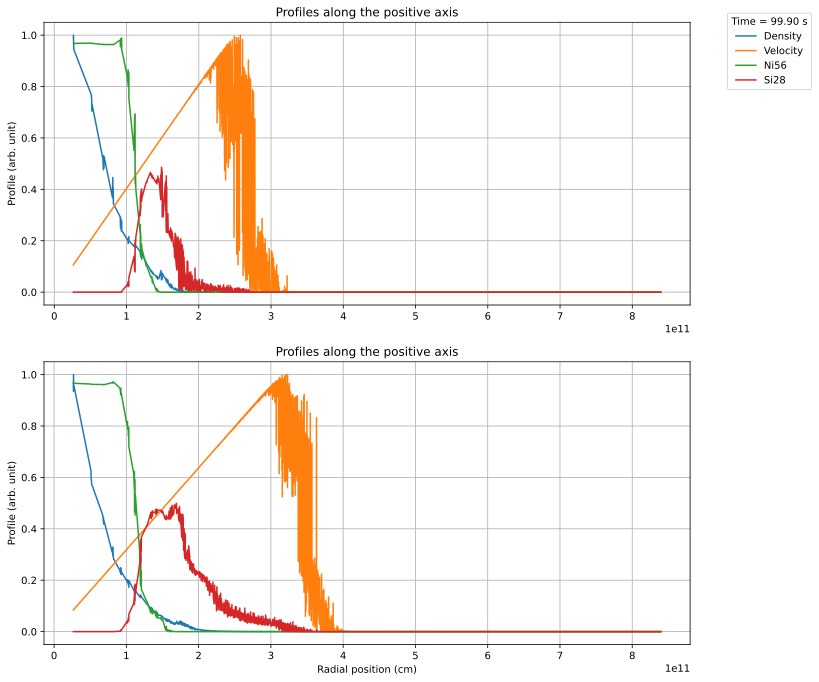

In [4]:
profile.create_profile(opening_angle=40)

In many cases you only want a very specific region from the snapshot, e.g. cutting out the dense, optically thick regions. This can be acchieved using the keywords `inner_radius` and `outer_radius`.

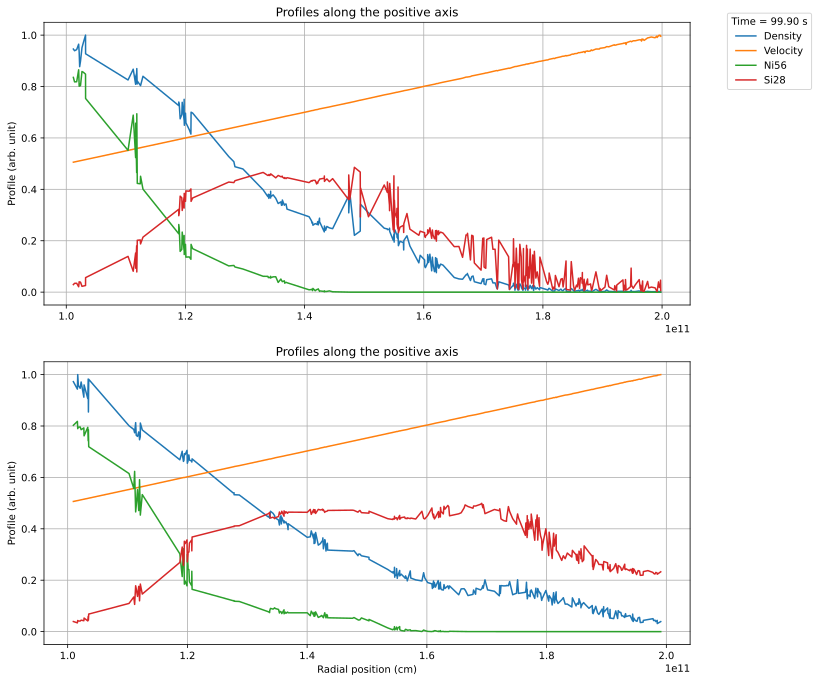

In [5]:
profile.create_profile(opening_angle=40, inner_radius=1e11, outer_radius=2e11)

Once you have created a profile of the desired region, you can export the profile to a `csvy` using the commented-out code below, which in turn can be used in a TARDIS model. Here you have to specify how many shells you want to export. The profiles are rebinned using [Scipys binned_statistic function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html), using the mean value of the data in each bin.

In [6]:
profile.export(20, "snapshot_converted_to_tardis.csvy", overwrite=True)

'snapshot_converted_to_tardis.csvy'

<div class="alert alert-info">

Note

By default, the `export` method will not overwrite existing files with the same file name. Setting `overwrite=True` allows overwriting -- for example, if `overwrite=True`, if you make changes and rerun the export your exported file will be updated without creaing an additional file.

</div>

During the export, the `yaml` header is automatically written and includes the time of the screenshot as the time for both the nuclear data as well as the density profile. Per default, the positive axis will be exported. the negative axis can be exported with `direction="neg"`.

All abundences will normalised such that roughly sum to 1, but slight deviations are expected to occur.

### Manually rebinning the data
Using `profile.rebin(<nshells>, statistic=<statistic>)`, you can manually rebin the data and use all `<statistic>` keywords accepted by the `scipy.stats.binned_statistic` function. In this case you should pass the `statistic=None` keyword to the `export` function, so the data does not get rebinned twice.

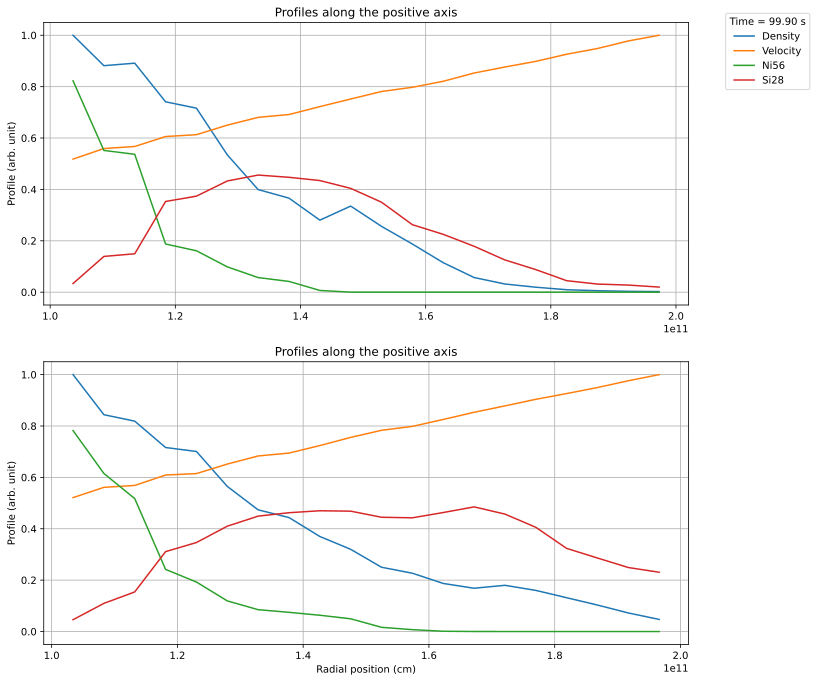

'rebinned_snapshot_converted_to_tardis.csvy'

In [7]:
profile.create_profile(opening_angle=40, inner_radius=1e11, outer_radius=2e11, show_plot=False)
profile.rebin(20)
profile.plot_profile()
plt.show()
profile.export(20, "rebinned_snapshot_converted_to_tardis.csvy", overwrite=True)

## Using the parser as a command line tool

You can also use the `tardis.io.arepo` package as a command line utility, e.g. if you are running batch jobs and want to automatically convert your snapshots from within you job-script.

To export the same profile as in the example above you can run:
```bash
python ./<location_of_arepo_parser>/arepo.py snapshot.hdf5 snapshot_converted.csvy -o 40 -n 20 --inner_radius 1e11 --outer_radius 2e11 -e ni56 si28 --save_plot plot.png --resolution 32 --plot_rebinned plot_binned.png
```

This will also save diagnostic plots of both the raw and rebinned profiles. For more information on how to use the command line tool run:
```bash
python ./<location_of_arepo_parser>/arepo.py --help
```

<div class="alert alert-info">



Note


The command line tool does only work with snapshot files, not with e.g. json files. It is in any case not advised to use json files as an intermediate step, as the become huge for higher resolutions.


</div>